In [1]:
import sys
import numpy as np
from importlib import reload
import pandas
import Parameters
reload(Parameters)
import Optimizer
reload(Optimizer)
import Results
reload(Results)
import Vehicle
reload(Vehicle)
import Check_solution
from minizinc import *
from datetime import datetime
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
from matplotlib import animation, rc
try:
    import docplex.cp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
    else:
        !pip install --user docplex
import docplex.cp
from docplex.cp.model import *
from sys import stdout

### Step 2: Model the data

In [10]:
blocks_excel = pandas.read_excel("data/Blocks.xlsx", sheet_name=0)

param=100

Block =[]
horizon = 1

for h in range(horizon):
    for row in blocks_excel.iterrows():
        id, typ, start, end, einet, ei = row[1].values
        b = Parameters.Blocks(id+h*100000, start, end, int(param*ei), typ)
        b.converter_start(h)
        b.converter_end(h)
        Block.append(b)

Block =[Block[i] for i in range(len(Block)) if Block[i].type == 'e2']

# Block =[Block[i] for i in range(50) if Block[i].type == 'e2']

In [11]:
EB_excel = pandas.read_csv(
    'data/Vehicles.txt', sep="\t")

rates=dict()
rate_e1=42/(3*60)
rate_e2=50*100/(380*60)
rates['e1']= rate_e1
rates['e2']= rate_e2

EBs =[]

for row in EB_excel.iterrows():
    id, typ = row[1].values
    EBs.append(Vehicle.EB(id, typ, rates[typ]))

EBs =[EBs[i] for i in range(len(EBs)) if EBs[i].type == 'e2']

# EBs=EBs[0:30]

M= Parameters.get_last_block(Block)+180

In [27]:
NUM_TRIPS = len(Block)
NUM_BUS=len(EBs)
NUM_NODES=NUM_TRIPS+2*NUM_BUS
NUM_LANES=6
NUM_SPOTS=5
C = 15
RATE=22
print(NUM_BUS, NUM_TRIPS)

30 98


### Step 3: Set up the prescriptive model

In [28]:
import Optimizer
reload(Optimizer)

Planning= Optimizer.Planning_model(Block, EBs, 'e2', rates, 100*param, 15*param, C, NUM_LANES, NUM_SPOTS)

In [29]:
solution, link_trip_to_EB, charge_events, parking_events_for_trip, parking_events_for_bus =Planning.solve(180, False)


Solving model....


In [21]:
solution.get_fail_status(), solution.get_solve_status()

('SearchHasNotFailed', 'Feasible')

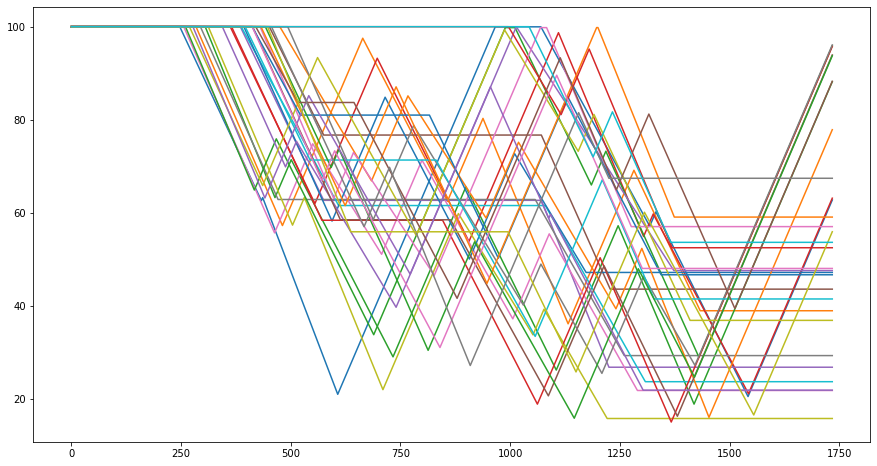

In [58]:
reload(Vehicle)
reload(Results)
import Check_solution
reload(Check_solution)

Planning_exit=Results.Results_planning(NUM_BUS, NUM_TRIPS, NUM_LANES, NUM_SPOTS, C, RATE, param, M, EBs, Block, link_trip_to_EB, charge_events, parking_events_for_trip, parking_events_for_bus)

Check_solution.check_solution(Planning_exit)
Planning_exit.plot_energies()

In [23]:
for trip in range(NUM_TRIPS):
    count=0
    for bus in range(NUM_BUS):
        if trip in Planning_exit.planning[bus]:
            count+=1
    if count!=1:
        print('error')

In [24]:
import pygame
from pygame.locals import *

def run(planning):
    FPS =1
    pygame.init()
    fpsClock=pygame.time.Clock()

    number_of_parking_lanes=planning.NUM_LANES
    number_of_spaces=planning.NUM_SPOTS
    unit_height=100
    unit_width =80

    SCREEN_WIDTH, SCREEN_HEIGHT = (number_of_parking_lanes+2)*unit_width, (number_of_spaces+1)*unit_height
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT), 0, 32)
    surface = pygame.Surface(screen.get_size())
    surface = surface.convert()
    surface.fill((255,255,255))


    class Lane(object):
        def __init__(self, lane_number):
            self.font = pygame.font.Font(None, 35)
            self.color = (0,0,0)
            self.lane_number= lane_number
            self.positions =  [((lane_number+1)*unit_width, unit_height)]

        def draw(self, surf):
            pygame.draw.rect(surf, self.color, (self.positions[0][0], self.positions[0][1], unit_width, number_of_spaces*unit_height),3)
            pygame.draw.rect(surf, self.color, (self.positions[0][0], 0, unit_width, unit_height),3)
            surface.blit(self.font.render('N°' + str(self.lane_number), True, (255,0,0)), (self.positions[0][0]+unit_width/4, unit_height/2, unit_width, unit_height))

    class Parking_space(object):
        def __init__(self, lane_number, space_number):
            self.color = (0,0,0)
            self.lane_number= lane_number
            self.space_number= space_number
            self.font = pygame.font.Font(None, 35)
            self.font_small = pygame.font.Font(None, 20)

        def draw(self, surf, t):
            pos_x = (self.lane_number+1)*unit_width
            pos_y= (self.space_number+1)*unit_height
            EB = planning.get_parking_at_spaces_at_t(self.lane_number, self.space_number,t)
            if EB != None:
                if EB.is_charged_at_t(t):
                    pygame.draw.rect(surf, (0,255,0), (pos_x, pos_y, unit_width, unit_height))
                pygame.draw.rect(surf, self.color, (pos_x, pos_y, unit_width, unit_height),1)
                surface.blit(self.font.render('EB', True, (0,0,0)), (pos_x+unit_width/4, pos_y+unit_height/10, unit_width, unit_height))
                surface.blit(self.font.render(str(EB.id), True, (0,0,0)), (pos_x+unit_width/20, pos_y+3*unit_height/10, unit_width, unit_height))
                surface.blit(self.font_small.render('SoC='+ str(np.round(EB.energy[t],1)) + '%', True, (0,0,0)), (pos_x+unit_width/20, pos_y+6*unit_height/10, unit_width, unit_height))
            else:
                pygame.draw.rect(surf, self.color, (pos_x, pos_y, unit_width, unit_height),1)

    if __name__ == '__main__':
        time_limit=planning.M-10
        Parking_lanes=[]
        Parking_spaces=[]
        for n in range(number_of_parking_lanes):
            Parking_lanes.append(Lane(n))
            for s in range(number_of_spaces):
                Parking_spaces.append(Parking_space(n, s))

        time=200
        running=True
        stop=False
        while running and time <time_limit:
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == KEYDOWN:
                    if event.key == K_SPACE:
                        stop= not stop
                    elif event.key == K_LEFT:
                        if FPS >=2:
                            FPS-=1
                    elif event.key == K_RIGHT:
                        FPS+=1
                    elif stop and event.key == K_UP:
                        time+=20
                    elif stop and event.key == K_DOWN:
                        time-=20

            surface.fill((255,255,255))
            for lane in Parking_lanes:
                lane.draw(surface)

            for space in Parking_spaces:
                space.draw(surface, time)

            screen.blit(surface, (0,0))
            font = pygame.font.Font(None, 36)
            text = font.render(str(time), 1, (10, 10, 10))
            textpos = text.get_rect()
            textpos.centerx = 20
            surface.blit(text, textpos)
            screen.blit(surface, (0,0))

            pygame.display.flip()
            pygame.display.update()
            if not stop:
                time+=1
            fpsClock.tick(FPS)
        if time ==time_limit:
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
        pygame.display.quit()
        pygame.quit()

pygame 2.4.0 (SDL 2.26.4, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [25]:
run(Planning_exit)